<a href="https://colab.research.google.com/github/my-quach/R-AI/blob/main/FACE_EMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import random

def split_data_dual(base_dir, face_output, emotion_output, split_ratio=0.8):
    base_dir = base_dir.strip()  # loại bỏ khoảng trắng đầu/cuối nếu có

    for person in os.listdir(base_dir):
        person_path = os.path.join(base_dir, person)
        if os.path.isdir(person_path):
            for emotion in os.listdir(person_path):
                emotion_path = os.path.join(person_path, emotion)
                if os.path.isdir(emotion_path):
                    files = os.listdir(emotion_path)
                    random.shuffle(files)
                    split_index = int(len(files) * split_ratio)
                    train_files = files[:split_index]
                    val_files = files[split_index:]

                    # 🔹 Ghi vào thư mục theo người (face)
                    for mode, file_list in zip(['train', 'val'], [train_files, val_files]):
                        face_target = os.path.join(face_output, mode, person, emotion)
                        os.makedirs(face_target, exist_ok=True)
                        for f in file_list:
                            src = os.path.join(emotion_path, f)
                            dst = os.path.join(face_target, f)
                            shutil.copy2(src, dst)

                    # 🔹 Ghi vào thư mục theo cảm xúc (emotion)
                    for mode, file_list in zip(['train', 'val'], [train_files, val_files]):
                        emotion_target = os.path.join(emotion_output, mode, emotion)
                        os.makedirs(emotion_target, exist_ok=True)
                        for f in file_list:
                            src = os.path.join(emotion_path, f)
                            dst = os.path.join(emotion_target, f)
                            shutil.copy2(src, dst)

# ✅ Đường dẫn gốc dữ liệu
original_data = '/content/drive/MyDrive/face'  # ✅ Đã sửa đúng path
original_data = '/content/drive/MyDrive/emotion'
# ✅ Nơi lưu dữ liệu sau khi chia
split_output_face = '/content/drive/MyDrive/face'
split_output_emotion = '/content/drive/MyDrive/emotion'

# ✅ Gọi hàm chia dữ liệu
split_data_dual(original_data, split_output_face, split_output_emotion, split_ratio=0.8)


In [2]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Đường dẫn thư mục dữ liệu đã chia
train_face = '/content/drive/MyDrive/face'
val_face = '/content/drive/MyDrive/face'
train_emotion = '/content/drive/MyDrive/emotion'
val_emotion = '/content/drive/MyDrive/emotion'

# Kích thước ảnh
IMG_SIZE = 224

# ✅ Tạo bộ sinh dữ liệu
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
)

val_datagen = ImageDataGenerator(rescale=1./255)

# ✅ Dataloader - Face
train_generator_face = train_datagen.flow_from_directory(
    train_face,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
val_generator_face = val_datagen.flow_from_directory(
    val_face,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ✅ Dataloader - Emotion
train_generator_emotion = train_datagen.flow_from_directory(
    train_emotion,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
val_generator_emotion = val_datagen.flow_from_directory(
    val_emotion,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ✅ Mô hình CNN - Face
model_face = Sequential()
model_face.add(Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model_face.add(MaxPooling2D(2,2))
model_face.add(Conv2D(64,(3,3),activation='relu'))
model_face.add(MaxPooling2D(2,2))
model_face.add(Conv2D(64,(3,3),activation='relu'))
model_face.add(Flatten())
model_face.add(Dense(64,activation='relu'))
model_face.add(Dense(train_generator_face.num_classes, activation='softmax'))

# ✅ Mô hình CNN - Emotion
model_emotion = Sequential()
model_emotion.add(Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model_emotion.add(MaxPooling2D(2,2))
model_emotion.add(Conv2D(64,(3,3),activation='relu'))
model_emotion.add(MaxPooling2D(2,2))
model_emotion.add(Conv2D(64,(3,3),activation='relu'))
model_emotion.add(Flatten())
model_emotion.add(Dense(64,activation='relu'))
model_emotion.add(Dense(train_generator_emotion.num_classes, activation='softmax'))





Found 100 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 96 images belonging to 6 classes.
Found 96 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
# Compile mô hình
model_face.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train mô hình - Face
history_face = model_face.fit(
    train_generator_face,
    epochs=50,
    validation_data=val_generator_face
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.2420 - loss: 2.3803 - val_accuracy: 0.2100 - val_loss: 1.5991
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.2354 - loss: 1.6299 - val_accuracy: 0.1800 - val_loss: 1.5944
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.1432 - loss: 1.6174 - val_accuracy: 0.3500 - val_loss: 1.5782
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.2856 - loss: 1.5661 - val_accuracy: 0.2200 - val_loss: 1.6203
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.2416 - loss: 1.6358 - val_accuracy: 0.3300 - val_loss: 1.4475
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.2146 - loss: 1.5183 - val_accuracy: 0.4800 - val_loss: 1.3980
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.3090 - loss: 1.5006 - val_accuracy: 0.4800 - val_loss: 1.3749
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step - accuracy: 0.3717 - loss: 1.4195 - val_accuracy: 0.5900 - val_loss: 1.1844
Epoch 9/

In [4]:
model_emotion.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train mô hình - Emotion
history_emotion = model_emotion.fit(
    train_generator_emotion,
    epochs=50,
    validation_data=val_generator_emotion
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 9s/step - accuracy: 0.1523 - loss: 3.6952 - val_accuracy: 0.2292 - val_loss: 2.1590
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 9s/step - accuracy: 0.2279 - loss: 2.0029 - val_accuracy: 0.2604 - val_loss: 1.7725
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.2904 - loss: 1.7725 - val_accuracy: 0.2604 - val_loss: 1.7339
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 9s/step - accuracy: 0.2630 - loss: 1.7306 - val_accuracy: 0.2604 - val_loss: 1.7150
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.2826 - loss: 1.7059 - val_accuracy: 0.2604 - val_loss: 1.7113
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 9s/step - accuracy: 0.2786 - loss: 1.6876 - val_accuracy: 0.2604 - val_loss: 1.7099
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.2474 - loss: 1.7346 - val_accuracy: 0.2604 - val_loss: 1.6993
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 9s/step - accuracy: 0.2474 - loss: 1.7257 - val_accuracy: 0.2604 - val_loss: 1.6982
Epoch 9/

In [5]:
model_face.save('model_face.h5')
model_emotion.save('model_emotion.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


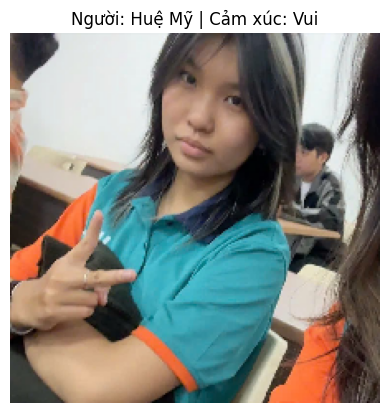

Người này là:Huệ Mỹ
Người này đang cảm thấy:Vui


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import load_img, img_to_array
import os

# Tải model nếu cần
 #model_face = load_model('model_face.h5')
 #model_emotion = load_model('model_emotion.h5')

# Lấy nhãn lớp
class_labels_face = list(train_generator_face.class_indices.keys())
class_labels_emotion = list(train_generator_emotion.class_indices.keys())

img_path = '/content/drive/MyDrive/face/Huệ Mỹ/vui/z6517320403160_8a07ff4aebfd8d126c3c10cec987d43a.jpg'



def predict_single_image(img_path):
    # Load và chuẩn hóa ảnh
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)

    # Dự đoán người
    prediction_face = model_face.predict(img_array)
    class_idx_face = np.argmax(prediction_face)
    predicted_face = class_labels_face[class_idx_face]

    # Dự đoán cảm xúc
    prediction_emotion = model_emotion.predict(img_array)
    class_idx_emotion = np.argmax(prediction_emotion)
    predicted_emotion = class_labels_emotion[class_idx_emotion]

    # Hiển thị ảnh + kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Người: {predicted_face} | Cảm xúc: {predicted_emotion}')
    plt.show()


    return predicted_face, predicted_emotion

# Call the function to get predictions and assign them to variables
predicted_face, predicted_emotion = predict_single_image(img_path)

#Now you can print the results
print(f'Người này là:{predicted_face}')
print(f'Người này đang cảm thấy:{predicted_emotion}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


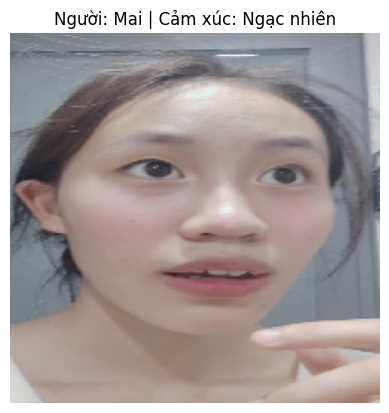

Người này là:Mai
Người này đang cảm thấy:Ngạc nhiên


In [11]:

import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import load_img, img_to_array
import os

# Lấy nhãn lớp
class_labels_face = list(train_generator_face.class_indices.keys())
class_labels_emotion = list(train_generator_emotion.class_indices.keys())

img_path = '/content/drive/MyDrive/face/Mai/Ngạc nhiên/z6518182068947_c92325173a4330fb4379062ac63b46fd.jpg'



def predict_single_image(img_path):
    # Load và chuẩn hóa ảnh
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)

    # Dự đoán người
    prediction_face = model_face.predict(img_array)
    class_idx_face = np.argmax(prediction_face)
    predicted_face = class_labels_face[class_idx_face]

    # Dự đoán cảm xúc
    prediction_emotion = model_emotion.predict(img_array)
    class_idx_emotion = np.argmax(prediction_emotion)
    predicted_emotion = class_labels_emotion[class_idx_emotion]

    # Hiển thị ảnh + kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Người: {predicted_face} | Cảm xúc: {predicted_emotion}')
    plt.show()


    return predicted_face, predicted_emotion

# Call the function to get predictions and assign them to variables
predicted_face, predicted_emotion = predict_single_image(img_path)

#Now you can print the results
print(f'Người này là:{predicted_face}')
print(f'Người này đang cảm thấy:{predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


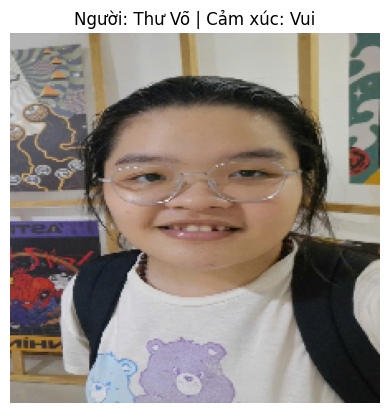

Người này là:Thư Võ
Người này đang cảm thấy:Vui


In [21]:

import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import load_img, img_to_array
import os

# Lấy nhãn lớp
class_labels_face = list(train_generator_face.class_indices.keys())
class_labels_emotion = list(train_generator_emotion.class_indices.keys())

img_path = '/content/drive/MyDrive/face/Thư Võ/Vui/v2.jpg'



def predict_single_image(img_path):
    # Load và chuẩn hóa ảnh
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)

    # Dự đoán người
    prediction_face = model_face.predict(img_array)
    class_idx_face = np.argmax(prediction_face)
    predicted_face = class_labels_face[class_idx_face]

    # Dự đoán cảm xúc
    prediction_emotion = model_emotion.predict(img_array)
    class_idx_emotion = np.argmax(prediction_emotion)
    predicted_emotion = class_labels_emotion[class_idx_emotion]

    # Hiển thị ảnh + kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Người: {predicted_face} | Cảm xúc: {predicted_emotion}')
    plt.show()


    return predicted_face, predicted_emotion

# Call the function to get predictions and assign them to variables
predicted_face, predicted_emotion = predict_single_image(img_path)

#Now you can print the results
print(f'Người này là:{predicted_face}')
print(f'Người này đang cảm thấy:{predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


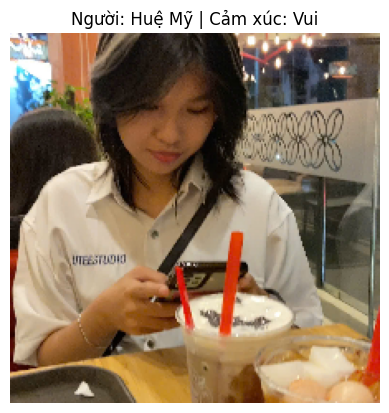

Người này là:Huệ Mỹ
Người này đang cảm thấy:Vui


In [13]:

import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import load_img, img_to_array
import os

# Lấy nhãn lớp
class_labels_face = list(train_generator_face.class_indices.keys())
class_labels_emotion = list(train_generator_emotion.class_indices.keys())

img_path = '/content/drive/MyDrive/face/Huệ Mỹ/vui/z6517320396427_8c44c9ef20953470724dd9022655ed5d.jpg'



def predict_single_image(img_path):
    # Load và chuẩn hóa ảnh
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)

    # Dự đoán người
    prediction_face = model_face.predict(img_array)
    class_idx_face = np.argmax(prediction_face)
    predicted_face = class_labels_face[class_idx_face]

    # Dự đoán cảm xúc
    prediction_emotion = model_emotion.predict(img_array)
    class_idx_emotion = np.argmax(prediction_emotion)
    predicted_emotion = class_labels_emotion[class_idx_emotion]

    # Hiển thị ảnh + kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Người: {predicted_face} | Cảm xúc: {predicted_emotion}')
    plt.show()


    return predicted_face, predicted_emotion

# Call the function to get predictions and assign them to variables
predicted_face, predicted_emotion = predict_single_image(img_path)

#Now you can print the results
print(f'Người này là:{predicted_face}')
print(f'Người này đang cảm thấy:{predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


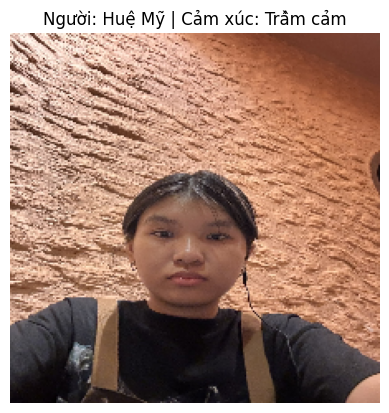

Người này là:Huệ Mỹ
Người này đang cảm thấy:Trầm cảm


In [14]:

import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import load_img, img_to_array
import os

# Lấy nhãn lớp
class_labels_face = list(train_generator_face.class_indices.keys())
class_labels_emotion = list(train_generator_emotion.class_indices.keys())

img_path = '/content/drive/MyDrive/face/Huệ Mỹ/Trầm cảm/bơ phờ.jpg'



def predict_single_image(img_path):
    # Load và chuẩn hóa ảnh
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)

    # Dự đoán người
    prediction_face = model_face.predict(img_array)
    class_idx_face = np.argmax(prediction_face)
    predicted_face = class_labels_face[class_idx_face]

    # Dự đoán cảm xúc
    prediction_emotion = model_emotion.predict(img_array)
    class_idx_emotion = np.argmax(prediction_emotion)
    predicted_emotion = class_labels_emotion[class_idx_emotion]

    # Hiển thị ảnh + kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Người: {predicted_face} | Cảm xúc: {predicted_emotion}')
    plt.show()


    return predicted_face, predicted_emotion

# Call the function to get predictions and assign them to variables
predicted_face, predicted_emotion = predict_single_image(img_path)

#Now you can print the results
print(f'Người này là:{predicted_face}')
print(f'Người này đang cảm thấy:{predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


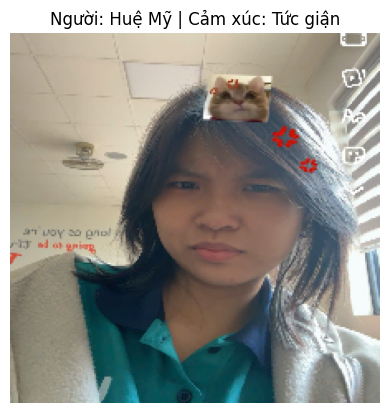

Người này là:Huệ Mỹ
Người này đang cảm thấy:Tức giận


In [16]:

import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import load_img, img_to_array
import os

# Lấy nhãn lớp
class_labels_face = list(train_generator_face.class_indices.keys())
class_labels_emotion = list(train_generator_emotion.class_indices.keys())

img_path = '/content/drive/MyDrive/face/Huệ Mỹ/tức giận/z6517389258582_5fba6f30991cc2714bd099b1ce2ace6f.jpg'



def predict_single_image(img_path):
    # Load và chuẩn hóa ảnh
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)

    # Dự đoán người
    prediction_face = model_face.predict(img_array)
    class_idx_face = np.argmax(prediction_face)
    predicted_face = class_labels_face[class_idx_face]

    # Dự đoán cảm xúc
    prediction_emotion = model_emotion.predict(img_array)
    class_idx_emotion = np.argmax(prediction_emotion)
    predicted_emotion = class_labels_emotion[class_idx_emotion]

    # Hiển thị ảnh + kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Người: {predicted_face} | Cảm xúc: {predicted_emotion}')
    plt.show()


    return predicted_face, predicted_emotion

# Call the function to get predictions and assign them to variables
predicted_face, predicted_emotion = predict_single_image(img_path)

#Now you can print the results
print(f'Người này là:{predicted_face}')
print(f'Người này đang cảm thấy:{predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


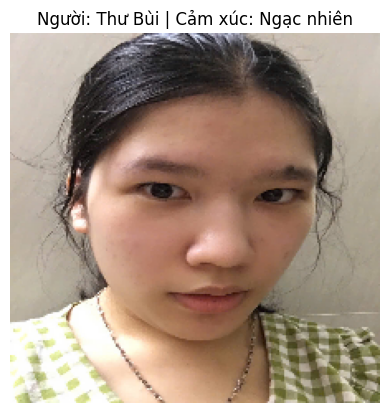

Người này là:Thư Bùi
Người này đang cảm thấy:Ngạc nhiên


In [20]:

import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import load_img, img_to_array
import os

# Lấy nhãn lớp
class_labels_face = list(train_generator_face.class_indices.keys())
class_labels_emotion = list(train_generator_emotion.class_indices.keys())

img_path = '/content/drive/MyDrive/face/Thư Bùi/NGẠC NHIÊN/z6519391545873_00bd6600119dd7c9d6de74e0543d063f.jpg'



def predict_single_image(img_path):
    # Load và chuẩn hóa ảnh
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)

    # Dự đoán người
    prediction_face = model_face.predict(img_array)
    class_idx_face = np.argmax(prediction_face)
    predicted_face = class_labels_face[class_idx_face]

    # Dự đoán cảm xúc
    prediction_emotion = model_emotion.predict(img_array)
    class_idx_emotion = np.argmax(prediction_emotion)
    predicted_emotion = class_labels_emotion[class_idx_emotion]

    # Hiển thị ảnh + kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Người: {predicted_face} | Cảm xúc: {predicted_emotion}')
    plt.show()


    return predicted_face, predicted_emotion

# Call the function to get predictions and assign them to variables
predicted_face, predicted_emotion = predict_single_image(img_path)

#Now you can print the results
print(f'Người này là:{predicted_face}')
print(f'Người này đang cảm thấy:{predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


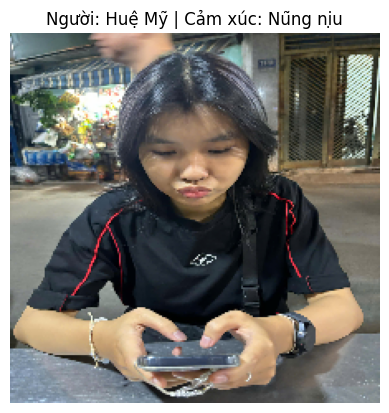

Người này là:Huệ Mỹ
Người này đang cảm thấy:Nũng nịu


In [32]:

import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import load_img, img_to_array
import os

# Lấy nhãn lớp
class_labels_face = list(train_generator_face.class_indices.keys())
class_labels_emotion = list(train_generator_emotion.class_indices.keys())

img_path = '/content/drive/MyDrive/face/Huệ Mỹ/Nũng nịu/hmuchu.jpg'



def predict_single_image(img_path):
    # Load và chuẩn hóa ảnh
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)

    # Dự đoán người
    prediction_face = model_face.predict(img_array)
    class_idx_face = np.argmax(prediction_face)
    predicted_face = class_labels_face[class_idx_face]

    # Dự đoán cảm xúc
    prediction_emotion = model_emotion.predict(img_array)
    class_idx_emotion = np.argmax(prediction_emotion)
    predicted_emotion = class_labels_emotion[class_idx_emotion]

    # Hiển thị ảnh + kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Người: {predicted_face} | Cảm xúc: {predicted_emotion}')
    plt.show()


    return predicted_face, predicted_emotion

# Call the function to get predictions and assign them to variables
predicted_face, predicted_emotion = predict_single_image(img_path)

#Now you can print the results
print(f'Người này là:{predicted_face}')
print(f'Người này đang cảm thấy:{predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


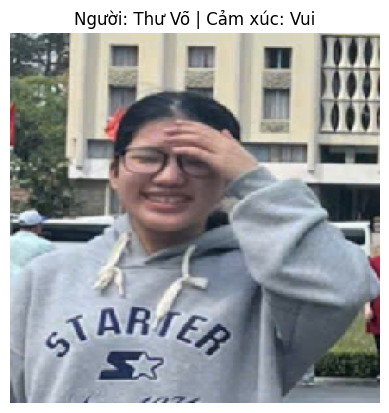

Người này là:Thư Võ
Người này đang cảm thấy:Vui


In [36]:

import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import load_img, img_to_array
import os

# Lấy nhãn lớp
class_labels_face = list(train_generator_face.class_indices.keys())
class_labels_emotion = list(train_generator_emotion.class_indices.keys())

img_path = '/content/drive/MyDrive/face/Thư Bùi/VUI/z6519391541808_d0e03eca6ae8d0cd3ec35fa0af5fcd76.jpg'



def predict_single_image(img_path):
    # Load và chuẩn hóa ảnh
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)

    # Dự đoán người
    prediction_face = model_face.predict(img_array)
    class_idx_face = np.argmax(prediction_face)
    predicted_face = class_labels_face[class_idx_face]

    # Dự đoán cảm xúc
    prediction_emotion = model_emotion.predict(img_array)
    class_idx_emotion = np.argmax(prediction_emotion)
    predicted_emotion = class_labels_emotion[class_idx_emotion]

    # Hiển thị ảnh + kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Người: {predicted_face} | Cảm xúc: {predicted_emotion}')
    plt.show()


    return predicted_face, predicted_emotion

# Call the function to get predictions and assign them to variables
predicted_face, predicted_emotion = predict_single_image(img_path)

#Now you can print the results
print(f'Người này là:{predicted_face}')
print(f'Người này đang cảm thấy:{predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


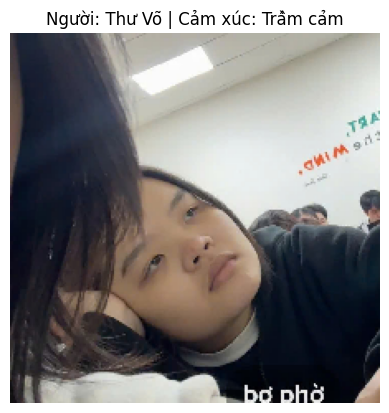

Người này là:Thư Võ
Người này đang cảm thấy:Trầm cảm


In [37]:

import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import load_img, img_to_array
import os

# Lấy nhãn lớp
class_labels_face = list(train_generator_face.class_indices.keys())
class_labels_emotion = list(train_generator_emotion.class_indices.keys())

img_path = '/content/drive/MyDrive/face/Thư Võ/Trầm cảm/c1.jpg'



def predict_single_image(img_path):
    # Load và chuẩn hóa ảnh
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)

    # Dự đoán người
    prediction_face = model_face.predict(img_array)
    class_idx_face = np.argmax(prediction_face)
    predicted_face = class_labels_face[class_idx_face]

    # Dự đoán cảm xúc
    prediction_emotion = model_emotion.predict(img_array)
    class_idx_emotion = np.argmax(prediction_emotion)
    predicted_emotion = class_labels_emotion[class_idx_emotion]

    # Hiển thị ảnh + kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Người: {predicted_face} | Cảm xúc: {predicted_emotion}')
    plt.show()


    return predicted_face, predicted_emotion

# Call the function to get predictions and assign them to variables
predicted_face, predicted_emotion = predict_single_image(img_path)

#Now you can print the results
print(f'Người này là:{predicted_face}')
print(f'Người này đang cảm thấy:{predicted_emotion}')